<a href="https://colab.research.google.com/github/Mihail-Chr/projects/blob/main/ML/car_cost/car_deep_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U pip
#!pip install cudf-cu11 cuml-cu11 cugraph-cu11 --extra-index-url=https://pypi.nvidia.com
!pip install cudf-cu12 cuml-cu12 cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
#!pip install cupy-cuda11x
!pip install cupy-cuda12x
!pip install --extra-index-url=https://pypi.nvidia.com rapids-cu12==25.8.0 cuml-cu12==25.8.0 cupy-cuda12x==12.0.0
#!pip install --extra-index-url=https://pypi.nvidia.com rapids-cu11==25.6.0 cuml-cu11==25.6.0 cupy-cuda11x==12.0.0

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 91.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
ERROR: Could not find a version that satisfies the requirement rapids-cu12==25.8.0 (from versions: none)
ERROR: No matching distribution found for rapids-cu12==25.8.0


In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.13 environment at: /usr
Resolved 175 packages in 507ms
 Downloaded cuproj-cu12
 Downloaded rmm-cu12
 Downloaded cudf-cu12
 Downloaded libkvikio-cu12
 Downloaded ucx-py-cu12
 Downloaded pylibcugraph-cu12
 Downloaded bokeh
 Downloaded librmm-cu12
 Downloaded cuspatial-cu12
 Downloaded cucim-cu12
 Downloaded cugraph-cu12
 Downloaded cuml-cu12
 Downloaded pylibcudf-cu12
 Downloaded nvidia-nvcomp-cu12
 Downloaded libcuspatial-cu12
 Downloaded libraft-cu12
 Downloaded libcudf-cu12
 Downloaded libcuml-cu12
 Downloaded raft-dask-cu12
 Downloaded libcuvs-cu12
 Downloaded libcugraph-cu12
Prepared 31 packages in 1m 10s
Uninstalled 31 packages in 830ms
Installed 54 packages in 433ms
 + arrow==1.3.0
 - bokeh==3.7.3
 + bokeh==3.6.3
 + cucim-cu12==25.4.0
 - cudf-cu12==25.6.0 (from https://pypi.nvidia.com/cudf-cu12/cudf_cu12-25.6.0-cp311-cp311-manylin

In [5]:
!pip install polars catboost numba phik
# cudf-polars-cu12
# cupy-cuda11x lightgbm scikit-learn matplotlib seaborn cudf-cu12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.0/679.0 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [catboost]


In [3]:
import torch
print(torch.cuda.is_available())


True


In [18]:
import time
import polars as pl
import cudf
import cupy as cp
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from phik.report import plot_correlation_matrix
from phik import phik_matrix


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,PassiveAggressiveRegressor,SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from cuml.linear_model import LinearRegression as cuLinearRegression, Ridge as cuRidge
from cuml.neighbors import KNeighborsRegressor as cuKNeighborsRegressor
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from cuml.preprocessing import StandardScaler as cuStandardScaler

from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings('ignore')
RANDOM_STATE = 255

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

def transform_bool(data,  true_val, false_val):
    return (data == true_val).cast(pl.Int32)

In [8]:
def preprocess_data(df):
    # Обработка пропусков
    df = df.with_columns([
        pl.col("VehicleType").fill_null("other"),
        pl.col("Gearbox").fill_null("other"),
        pl.col("Model").fill_null("other"),
        pl.col("FuelType").fill_null("other"),
        pl.col("Repaired").fill_null("other")
    ])

    # Фильтрация по году регистрации
    df = df.filter(
        (pl.col("RegistrationYear") >= 1950) &
        (pl.col("RegistrationYear") <= 2023)
    )

    # Фильтрация по цене
    df = df.filter(
        (pl.col("Price") >= 100) &
        (pl.col("Price") <= 150000)
    )

    # Преобразование bool
    df = df.with_columns([
        transform_bool(pl.col("Repaired"), "yes", "no").alias("Repaired")
    ])

    # Удаление ненужных столбцов
    df = df.drop(["DateCrawled", "DateCreated", "LastSeen", "NumberOfPictures", "PostalCode"])

    return df

'PHIK матрица '

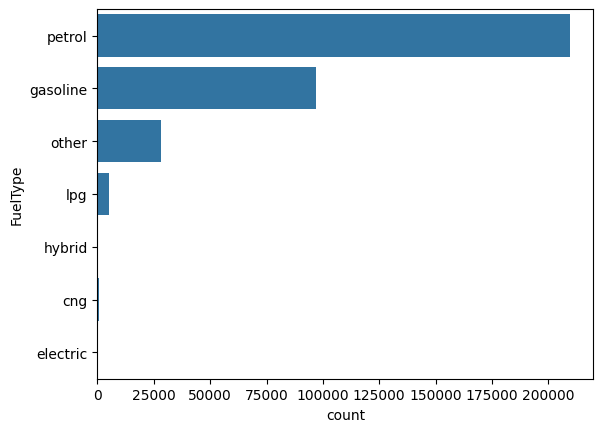

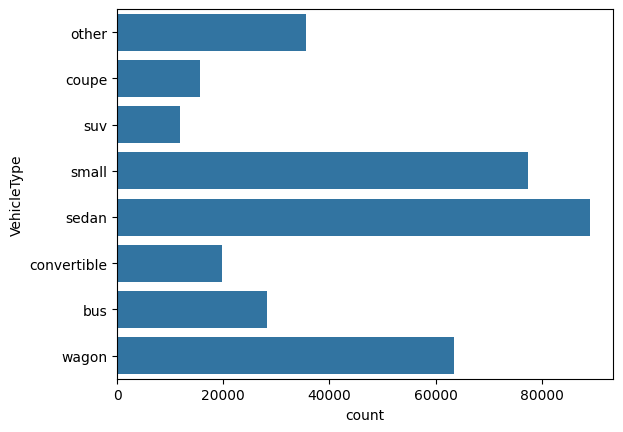

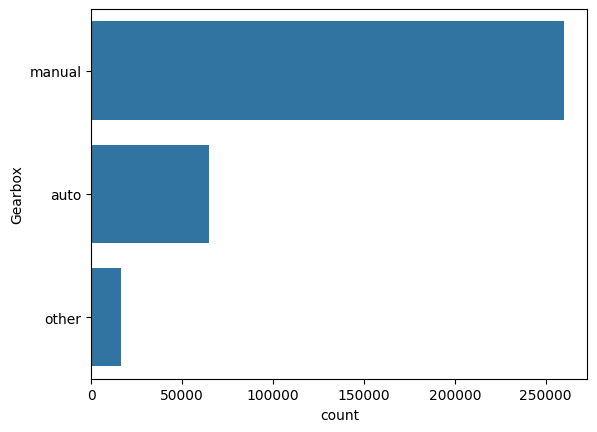

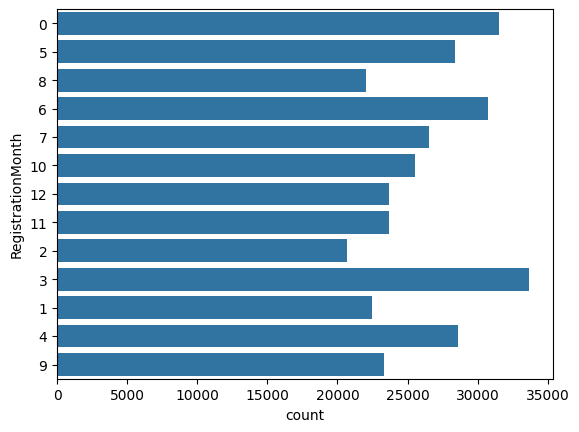

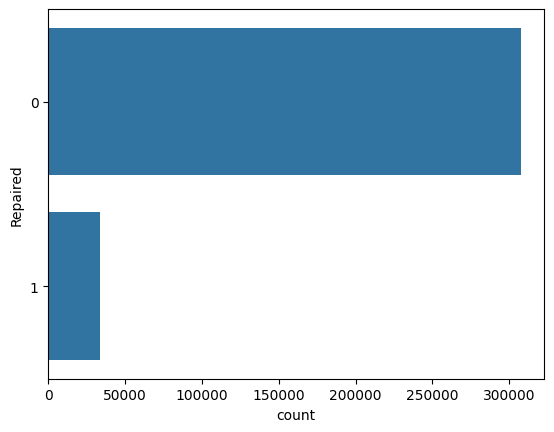

'Price'

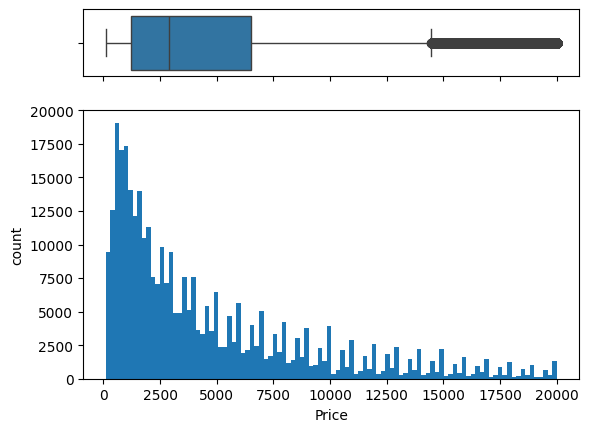

'RegistrationYear'

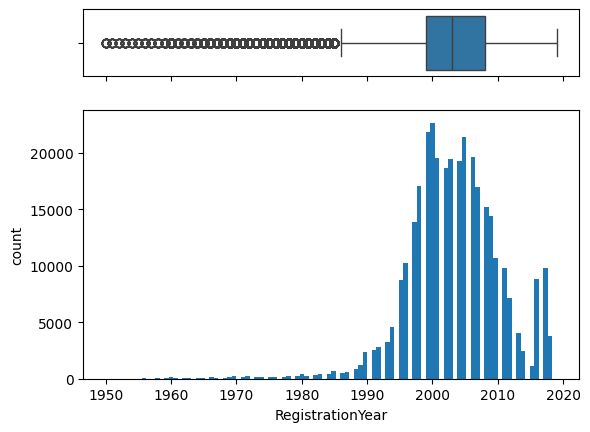

'Power'

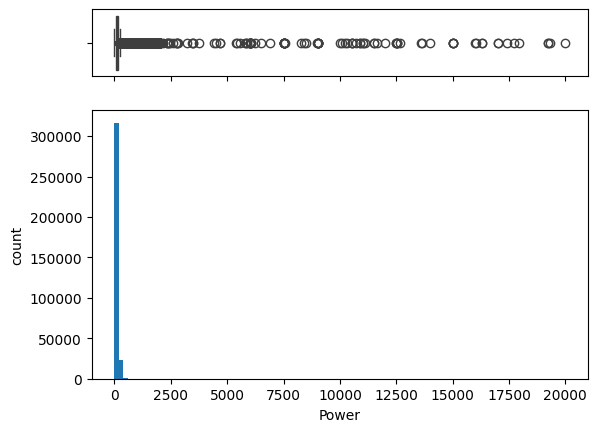

'Kilometer'

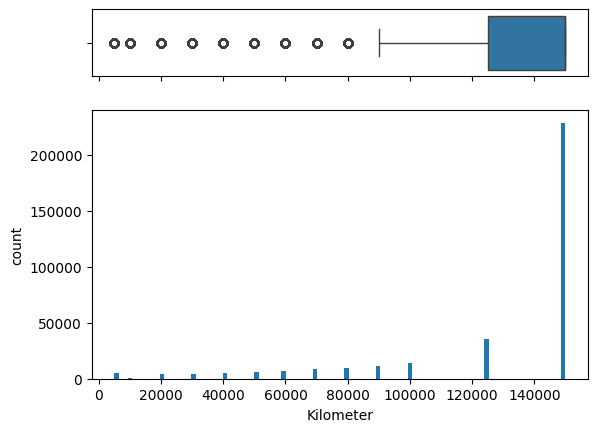

In [9]:
df = pl.read_csv('/content/drive/MyDrive/data/autos.csv')
df = preprocess_data(df)
#df1 = df.to_pandas()
cat_col = ['Model','FuelType','VehicleType','Gearbox','RegistrationMonth','Repaired'] #'Brand',
num_col = ['Price','RegistrationYear','Power','Kilometer']

col_auto_df = ['Price','Model','RegistrationYear','RegistrationMonth',
           'FuelType','VehicleType','Gearbox','Power','Kilometer','Repaired']#'Brand',

interval_cols = num_col
avto_df = df.clone()
avto_df[cat_col] = avto_df[cat_col].cast(pl.String)
# 'PHIK матрица'
display ('PHIK матрица ')


for i in cat_col:
    if avto_df[i].n_unique()<20:
        sns.countplot(y=i, data=avto_df)
        plt.show()

for n in num_col:
    display(n)
    fig, (ax_box, ax_hist) = plt.subplots(2,sharex = True,gridspec_kw = {'height_ratios': (.20, .80)})
    sns.boxplot(x = avto_df[n], ax = ax_box)
    plt.hist(avto_df[n],bins=100)
    ax_box.set(xlabel = '')
    ax_hist.set(xlabel = n)
    ax_hist.set(ylabel = 'count')
    plt.show()

In [10]:
# Разделение данных на признаки и целевую переменную
X = df.drop(['Price','Brand'])
y = df['Price']
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Подготовка данных для моделей на CPU и GPU
# Для CPU моделей: оставляем в pandas (или numpy)
# Для GPU моделей: конвертируем в cuDF
# Конвертируем X_train, X_test, y_train, y_test в cuDF
X_train_cudf = cudf.DataFrame.from_arrow(X_train.to_arrow())
X_test_cudf = cudf.DataFrame.from_arrow(X_test.to_arrow()) #.DataFrame.from_pandas
y_train_cudf = cudf.Series(y_train) #y_train.collect(engine="gpu")#cudf.Series(y_train.values)  # предполагая, что y_train - pandas Series
y_test_cudf = cudf.Series(y_test) #y_train.collect(engine="gpu")#cudf.Series(y_test.values)

In [12]:
# Определение числовых и категориальных признаков
numerical_cols = ["RegistrationYear", "Power", "Kilometer", "RegistrationMonth"]
categorical_cols = ["VehicleType", "Gearbox", "Model", "FuelType", "Repaired"] #"Brand",

# Создание предобработчика для CPU
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

# Предобработка данных на CPU
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Предобработка на GPU
scaler = cuStandardScaler()
X_train_cudf[numerical_cols] = scaler.fit_transform(X_train_cudf[numerical_cols])
X_test_cudf[numerical_cols] = scaler.transform(X_test_cudf[numerical_cols])

# OneHotEncoding на GPU
#for col in categorical_cols:
    #onehot = X_train_cudf[col].one_hot_encoded(list(X_train_cudf[col].unique()))
    #X_train_cudf = cudf.concat([X_train_cudf.drop(col), onehot], axis=1)
X_train_cudf = cudf.get_dummies(X_train_cudf, columns=categorical_cols)

    #onehot = X_test_cudf[col].one_hot_encoded(list(X_test_cudf[col].unique()))
    #X_test_cudf = cudf.concat([X_test_cudf.drop(col), onehot], axis=1)
X_test_cudf = cudf.get_dummies(X_test_cudf, columns=categorical_cols)

In [19]:
models_cpu = {
     "Dummy": DummyRegressor(),
     "SVR": SVR(),
     "PassiveAggressive": PassiveAggressiveRegressor(),
     "SGD": SGDRegressor(),

 }
# Модели, которые будем запускать на GPU через cuML
models_gpu_ml = {
     "cuLinearRegression": cuLinearRegression(),
     "cuRidge": cuRidge(),
     "cuKNeighbors": cuKNeighborsRegressor(),
     "cuRandomForest": cuRandomForestRegressor(),
 }
# Модели, которые могут использовать GPU через свои реализации (CatBoost, LGBM)
models_gpu_other = {
     "CatBoost": CatBoostRegressor(verbose=0, allow_writing_files=False, task_type='GPU'),
     "LGBM": LGBMRegressor(device='gpu'),
 }

In [ ]:
 results = []

  # 1. Обучение моделей на CPU (используем X_train, y_train в формате pandas)
 for name, model in models_cpu.items():
        start = time.time()
        model.fit(X_train_processed, y_train)
        train_time = time.time() - start
        start = time.time()
        y_pred = model.predict(X_test_processed)
        predict_time = time.time() - start
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        results.append({
            'model': name,
            'train_time': train_time,
            'predict_time': predict_time,
            'rmse': rmse,
            'mae': mae,
            'type': 'CPU'
        })

# 2. Обучение моделей на GPU через cuML (используем X_train_cudf, y_train_cudf)
for name, model in models_gpu_ml.items():
     start = time.time()
     model.fit(X_train_cudf, y_train_cudf)
     train_time = time.time() - start
     start = time.time()
     y_pred = model.predict(X_test_cudf)
     predict_time = time.time() - start
     # Переведем предсказания в numpy для метрик
     y_pred_np = y_pred.to_array()  # для cuML
     rmse = np.sqrt(mean_squared_error(y_test, y_pred_np))
     mae = mean_absolute_error(y_test, y_pred_np)
     results.append({
         'model': name,
         'train_time': train_time,
         'predict_time': predict_time,
         'rmse': rmse,
         'mae': mae,
         'type': 'GPU (cuML)'
     })
# 3. Обучение CatBoost и LGBM на GPU (но данные в pandas)
for name, model in models_gpu_other.items():
     start = time.time()
     model.fit(X_train_processed, y_train)
     train_time = time.time() - start
     start = time.time()
     y_pred = model.predict(X_test_processed)
     predict_time = time.time() - start
     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
     mae = mean_absolute_error(y_test, y_pred)
     results.append({
         'model': name,
         'train_time': train_time,
         'predict_time': predict_time,
         'rmse': rmse,
         'mae': mae,
         'type': 'GPU (other)'
     })
# Соберем результаты в DataFrame
results_df = pl.DataFrame(results)

In [ ]:


# CPU модели
cpu_results = train_evaluate_models(
    models_cpu, X_train_processed, y_train, X_test_processed, y_test, 'CPU'
)
results.extend(cpu_results)

# cuML GPU модели
gpu_ml_results = train_evaluate_models(
    models_gpu_ml, X_train_cudf, y_train_cudf, X_test_cudf, y_test_cudf, 'GPU (cuML)'
)
results.extend(gpu_ml_results)

# Другие GPU модели
gpu_other_results = train_evaluate_models(
    models_gpu_other, X_train_processed, y_train, X_test_processed, y_test, 'GPU (other)'
)
results.extend(gpu_other_results)

# Создаем DataFrame с результатами
results_df = pl.DataFrame(results)

In [ ]:
# Визуализация результатов
plt.figure(figsize=(14, 8))
sns.barplot(x='rmse', y='model', data=results_df.to_pandas(), hue='device')
plt.title('RMSE by Model and Device')
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='train_time', y='model', data=results_df.to_pandas(), hue='device')
plt.title('Training Time by Model and Device')
plt.xlabel('Training Time (s)')
plt.ylabel('Model')
plt.xscale('log')
plt.show()

# Выбор лучшей модели
best_model_info = results_df.sort('rmse').row(0)
best_model_name = best_model_info['model']
best_model_type = best_model_info['device']

print(f"Best model: {best_model_name} ({best_model_type})")
print(f"RMSE: {best_model_info['rmse']:.2f}")
print(f"MAE: {best_model_info['mae']:.2f}")
print(f"Training time: {best_model_info['train_time']:.2f}s")

In [ ]:
 Оценка важности признаков для лучшей модели
if best_model_name == "cuRandomForest":
    model = models_gpu_ml["cuRandomForest"]
    importances = model.feature_importances_
    features = X_train_cudf.columns.to_arrow().to_pylist()
elif best_model_name == "RandomForest":
    model = models_cpu["RandomForest"]
    importances = model.feature_importances_
    features = preprocessor.get_feature_names_out()
elif best_model_name == "CatBoost":
    model = models_gpu_other["CatBoost"]
    importances = model.get_feature_importance()
    features = preprocessor.get_feature_names_out()
else:
    print("Feature importance not available for this model")
    importances = None

if importances is not None:
    # Сортировка важностей
    sorted_idx = np.argsort(importances)[::-1][:20]
    sorted_features = [features[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]

    # Визуализация
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_importances, y=sorted_features)
    plt.title(f'Top 20 Feature Importances ({best_model_name})')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

In [ ]:
# Визуализация предсказаний лучшей модели
if "cu" in best_model_name:
    model = models_gpu_ml.get(best_model_name)
    y_pred = model.predict(X_test_cudf).to_array()
elif best_model_name in models_gpu_other:
    model = models_gpu_other[best_model_name]
    y_pred = model.predict(X_test_processed)
else:
    model = models_cpu[best_model_name]
    y_pred = model.predict(X_test_processed)

# График фактических и предсказанных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Prices ({best_model_name})')
plt.show()


In [ ]:
# Распределение ошибок
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.title('Distribution of Prediction Errors')
plt.show()